In [1]:
import sys
sys.path.append("../..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_utils      import *
from model_utils     import get_network
from tqdm import tqdm
from torchvision import transforms as T
from matplotlib import cm
import torchvision
from random import shuffle, choice, seed
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
channel, im_size, train_n_classes, test_n_classes, dst_train, dst_test = get_dataset(
        "CIFAR10",
        "../../data",
        zca=False
    )
assert train_n_classes == test_n_classes
test_loader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
test_img = []
test_label = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        test_img.append(x)
        test_label.append(y)
test_img = torch.vstack(test_img).to(device)
test_label = torch.hstack(test_label).to(device)
print(test_img.shape)
print(test_label.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 46.27it/s]


torch.Size([10000, 3, 32, 32])
torch.Size([10000])


In [4]:
# generate mixing accuracy for distilled data
ipc_acc = []
for ipc in tqdm([0, 2, 10, 50, 250]):
    if ipc != 0:
        label_indices = [[] for _ in range(train_n_classes)]
        for i, (x,y) in enumerate(dst_train):
            label_indices[y].append(i)
        seed(1) # fix seed
        for list in label_indices:
            shuffle(list)
        indices = []
        for list in label_indices:
            indices += list[:ipc]
        dst_train_subset = torch.utils.data.Subset(dst_train, indices)
        train_loader_subset = torch.utils.data.DataLoader(dst_train_subset, batch_size=256, shuffle=False, num_workers=8)
        train_data = []
        train_label = []
        for x,y in train_loader_subset:
            train_data.append(x.detach())
            train_label.append(y.detach())
        train_data = torch.vstack(train_data).to(device)
        train_label = torch.hstack(train_label).to(device)
    
    distilled_acc = []
    for i in tqdm(range(4)):
        data = torch.load(f"../../DD_data/{i}.pt")
        synthetic_data = data["data"]
        synthetic_label = data["label"]
        if ipc == 0:
            new_data = synthetic_data.to(device)
            new_label = synthetic_label.to(device)
        else: # combine distilled and real data
            new_data = torch.vstack([synthetic_data, train_data]).to(device)
            new_label = torch.hstack([synthetic_label, train_label]).to(device)
        torch.manual_seed(1) # fix seed to remove impact of random initialization
        np.random.seed(1)
        distilled_model = get_network("ConvNet", channel, train_n_classes, im_size).to(device)
        optim = torch.optim.SGD(distilled_model.parameters(), lr=0.01, momentum=0.9)
        distilled_model.train()
        criterion = torch.nn.CrossEntropyLoss()
        for e in range(300):
            pred = distilled_model(new_data)
            assert len(pred) == 1
            loss = criterion(pred[-1], new_label)
            optim.zero_grad()
            loss.backward()
            optim.step()

        distilled_model.eval()
        total = 0
        correct = 0
        test_predictions = []
        correctness = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                pred = distilled_model(x)
                assert len(pred) == 1
                pred = torch.argmax(pred[-1], dim=1)
                test_predictions += pred.tolist()
                correctness += (pred == y).tolist()
                correct += torch.sum(pred == y).item()
                total += x.shape[0]
        test_accuracy = correct/total
        distilled_acc.append(test_accuracy)
    ipc_acc.append(distilled_acc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.63s/it]


In [6]:
# generate accuracies for real data
seed(9999)
rand_acc = []
label_indices = [[] for _ in range(train_n_classes)]
for i, (x,y) in enumerate(dst_train):
    label_indices[y].append(i)
for list in label_indices:
    shuffle(list)
indices = []
for list in label_indices:
    indices += list[:10]
dst_train_subset = torch.utils.data.Subset(dst_train, indices)
train_loader_subset = torch.utils.data.DataLoader(dst_train_subset, batch_size=256, shuffle=False, num_workers=8)
train_data = []
train_label = []
for x,y in train_loader_subset:
    train_data.append(x.detach())
    train_label.append(y.detach())
synthetic_data = torch.vstack(train_data).to(device)
synthetic_label = torch.hstack(train_label).to(device)

for ipc in tqdm([0, 2, 10, 50, 250]):
    if ipc != 0:
        label_indices = [[] for _ in range(train_n_classes)]
        for i, (x,y) in enumerate(dst_train):
            label_indices[y].append(i)
        seed(1)
        for list in label_indices:
            shuffle(list)
        indices = []
        for list in label_indices:
            indices += list[:ipc]
        dst_train_subset = torch.utils.data.Subset(dst_train, indices)
        train_loader_subset = torch.utils.data.DataLoader(dst_train_subset, batch_size=256, shuffle=False, num_workers=8)
        train_data = []
        train_label = []
        for x,y in train_loader_subset:
            train_data.append(x.detach())
            train_label.append(y.detach())
        train_data = torch.vstack(train_data).to(device)
        train_label = torch.hstack(train_label).to(device)
        new_data = torch.vstack([synthetic_data, train_data]).to(device)
        new_label = torch.hstack([synthetic_label, train_label]).to(device)
    else:
        new_data = synthetic_data.to(device)
        new_label = synthetic_label.to(device)
    torch.manual_seed(1)
    np.random.seed(1)
    distilled_model = get_network("ConvNet", channel, train_n_classes, im_size).to(device)
    optim = torch.optim.SGD(distilled_model.parameters(), lr=0.01, momentum=0.9)
    distilled_model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for e in range(300):
        pred = distilled_model(new_data)
        assert len(pred) == 1
        loss = criterion(pred[-1], new_label)
        optim.zero_grad()
        loss.backward()
        optim.step()

    distilled_model.eval()
    total = 0
    correct = 0
    test_predictions = []
    correctness = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred = distilled_model(x)
            assert len(pred) == 1
            pred = torch.argmax(pred[-1], dim=1)
            test_predictions += pred.tolist()
            correctness += (pred == y).tolist()
            correct += torch.sum(pred == y).item()
            total += x.shape[0]
    test_accuracy = correct/total
    rand_acc.append(test_accuracy)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.70s/it]


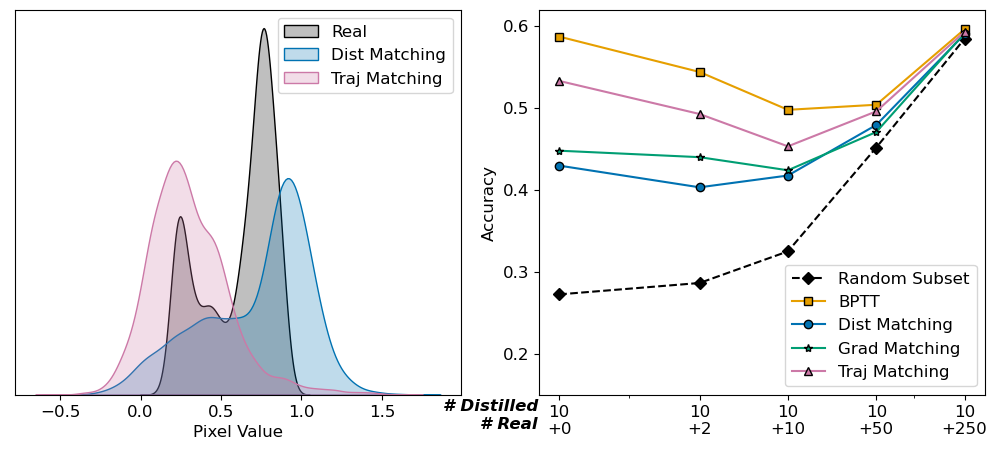

In [7]:
plt.rcParams.update({'font.size': 12})
colours = ["#000000", "#E69F00", "#0072B2", "#009E73", "#CC79A7"]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# visualize pixel intensity of distilled data
inv_transform = T.Compose([  T.Normalize(mean = [ 0., 0., 0. ],
                                std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                            T.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                std = [ 1., 1., 1. ]),
                        ])
data = torch.load(f"../../DD_data/3.pt")
synthetic_data = data["data"].detach().cpu()
data = torch.load(f"../../DD_data//1.pt")
synthetic_data2 = data["data"].detach().cpu()
sns.kdeplot(inv_transform(test_img[3,:,:,:]).cpu().flatten(), label='Real', fill=True, color=colours[0])
sns.kdeplot(inv_transform(synthetic_data2[9,:,:,:]).flatten(), label='Dist Matching', fill=True, color=colours[2])
sns.kdeplot(inv_transform(synthetic_data[8,:,:,:]).flatten(), label='Traj Matching', fill=True, color=colours[4])
plt.legend()
plt.yticks([])
plt.ylabel(None)
plt.xlabel("Pixel Value")

plt.subplot(1,2,2)
labels = ["BPTT", "Dist Matching", "Grad Matching", "Traj Matching"]
markers = ["s", "o", "*", "^"]
plt.plot([0, 2, 10, 50, 250], rand_acc, marker='D', linestyle='dashed', label='Random Subset', markeredgecolor='black',c=colours[0])
for i in range(4):
    plt.plot([0, 2, 10, 50, 250], np.array(ipc_acc)[:,i], marker=markers[i], label=labels[i], markeredgecolor='black',c=colours[i+1])
plt.xscale('symlog')
ticks = [0, 2, 10, 50, 250]
labels = ['10\n+0', '10\n+2', '10\n+10', '10\n+50', '10\n+250']

plt.xticks(ticks, labels)
plt.ylabel("Accuracy")
plt.ylim(0.15, 0.62)
plt.text(-0.3,0.1090,"# Distilled\n# Real", horizontalalignment='right', fontstyle='italic', fontweight='bold')

plt.subplots_adjust(left=0.02, right=0.99, wspace=0.175)
plt.legend(ncol=1)
